<a href="https://colab.research.google.com/github/malcolmfisher103/Bioinformatic-Scripts/blob/main/Session_Expression_data_graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
# @title Specify Genes
genes_to_plot = ["shh.L", "tbxt.L", "wnt7a.L"] # @param {type:"raw"}

In [16]:
# @title Imports
import argparse
import requests
from io import StringIO
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np  # Add this line
from matplotlib.ticker import LogLocator
from scipy.interpolate import interp1d

In [17]:
# @title Load data
def load_tpm_matrix():
    return pd.read_csv('https://bigfrog.xenbase.org/xenbase/genomics/GEO/GSE73430/XENLA_10.1/RNA-Seq/ExpressionFiles/Genes_TPM_Matrix.txt', sep='\t', index_col=0)

def load_gene_info():
    #return pd.read_csv('https://xenbase-bio1.ucalgary.ca/cgi-bin/reports/models_gene_info.cgi', sep='\t', index_col=0)
    url = 'https://xenbase-bio1.ucalgary.ca/cgi-bin/reports/models_gene_info.cgi'

    # Set up retry strategy (important for unstable servers)
    session = requests.Session()
    retries = Retry(
        total=5,
        backoff_factor=1,
        status_forcelist=[500, 502, 503, 504],
        raise_on_status=False
    )
    session.mount('https://', HTTPAdapter(max_retries=retries))

    # Fetch file with streaming
    response = session.get(url, timeout=60)
    response.raise_for_status()

    # Decode safely (Xenbase data often uses latin1)
    decoded_text = response.content.decode('latin1')

    # Read into pandas
    return pd.read_csv(StringIO(decoded_text), sep='\t', index_col=0)

def load_gsm_sample_mapping():
    return pd.read_csv('https://bigfrog.xenbase.org/xenbase/genomics/GEO/GSE73430/XENLA_10.1/RNA-Seq/gsm_to_track.txt', sep='\t')

def load_gsm_srr_mapping():
    return pd.read_csv('https://download.xenbase.org/xenbase/GenePageReports/geo_srr_metadata_chd.txt', sep='\t', encoding='ISO-8859-1')

def create_gsm_to_srr_mapping(gsm_srr_mapping):
    return gsm_srr_mapping[['SRR', 'GSM']]

In [18]:
# @title substitute_gene_symbols
def substitute_gene_symbols(tpm_matrix, gene_info):

  gene_info.columns = gene_info.columns.str.upper()  # Normalize casing
# Drop rows with null values in column 1 and column 2 in file 2
  gene_info = gene_info.dropna(subset=['GENE_SYMBOL', 'MODEL_NAME'])

# Drop duplicates in file 2 based on column 2
  gene_info = gene_info.drop_duplicates(subset=['MODEL_NAME'])

# Create a mapping dictionary from column 2 to column 1 in file 2
  mapping = dict(zip(gene_info['MODEL_NAME'], gene_info['GENE_SYMBOL']))

# Replace values in column 1 of file 1 with corresponding values from file 2
  tpm_matrix['Gene'] = tpm_matrix['Gene'].map(mapping).fillna(tpm_matrix['Gene'])

# Save the modified DataFrame back to file1.csv or use it as needed
#tpm_matrix.to_csv('modified_file1.csv', index=False)
  return tpm_matrix

In [19]:
# @title process_data
def process_data(tpm_matrix, gene_info, gsm_sample_mapping, gsm_srr_mapping):
    # Substituting gene symbols
    tpm_matrix = substitute_gene_symbols(tpm_matrix, gene_info) #This works

    # Mapping GSMs to SRRs
    gsm_to_srr = create_gsm_to_srr_mapping(gsm_srr_mapping)

    # Select columns 2 and 6 to create a DataFrame with Track Name and GSMs
    gsm_mapping = gsm_sample_mapping[['Track Name', 'GSMs']]

    # Convert GSMs column to list if it contains comma-separated values
    gsm_mapping.loc[:, 'GSMs'] = gsm_mapping['GSMs'].str.split(',')

    # Explode the list of GSMs to create multiple rows for each track name
    gsm_mapping = gsm_mapping.explode('GSMs')
    # Merge gsm_mapping with gsm_srr_mapping on the 'GSM' column to get corresponding SRRs
    track_srr_mapping = pd.merge(left=gsm_mapping, right=gsm_srr_mapping, left_on='GSMs', right_on='GSM', validate="1:m")
    # Group by 'Track Name' and aggregate the corresponding SRRs into lists
    track_srr_mapping = track_srr_mapping.groupby('Track Name')['SRR'].apply(list).reset_index()
    track_srr_mapping_expanded = track_srr_mapping.explode('SRR')
    #print(track_srr_mapping_expanded.head(10))

    srr_columns = tpm_matrix.columns.intersection(track_srr_mapping_expanded['SRR'])
    #print(srr_columns)
    srr_to_track = dict(zip(track_srr_mapping_expanded['SRR'], track_srr_mapping_expanded['Track Name']))

    # Grouping TPM matrix by SRRs
    tpm_matrix.rename(columns={col: srr_to_track.get(col, col) for col in srr_columns}, inplace=True)
    #print(tpm_matrix.head(10))

    # Melt the DataFrame to have a single column for the gene and the rest for values
    tpm_matrix = pd.melt(tpm_matrix, id_vars=['Gene'], var_name='Column')

    # Extract the unique column names excluding the first column (Gene)
    columns_to_merge = tpm_matrix['Column'].unique()[1:]

    # Group by track names and take the mean
    tpm_matrix_grouped = tpm_matrix.groupby(['Gene', 'Column']).mean().unstack()

    # Display the first 10 rows and first 5 columns
   # print(tpm_matrix_grouped.iloc[:10, :5])

    # Remove the hierarchical index and reset index
    tpm_matrix_grouped.columns = tpm_matrix_grouped.columns.droplevel()
    tpm_matrix_grouped.reset_index(inplace=True)

    #print(tpm_matrix_grouped.head(10))

    return tpm_matrix_grouped

In [20]:
# @title Main
def main():
    # Load data
    tpm_matrix = load_tpm_matrix()
    tpm_matrix = tpm_matrix.reset_index()
    # print(tpm_matrix.columns)
    gene_info = load_gene_info()
    gene_info = gene_info.reset_index()
    # print(gene_info.head(10))
    gsm_sample_mapping = load_gsm_sample_mapping()
    gsm_srr_mapping = load_gsm_srr_mapping()

    # Process data
    new_tpm_matrix = process_data(tpm_matrix, gene_info, gsm_sample_mapping, gsm_srr_mapping)

    # Output new_tpm_matrix to file
    new_tpm_matrix.to_csv('output.txt', sep='\t')

if __name__ == "__main__":
    main()

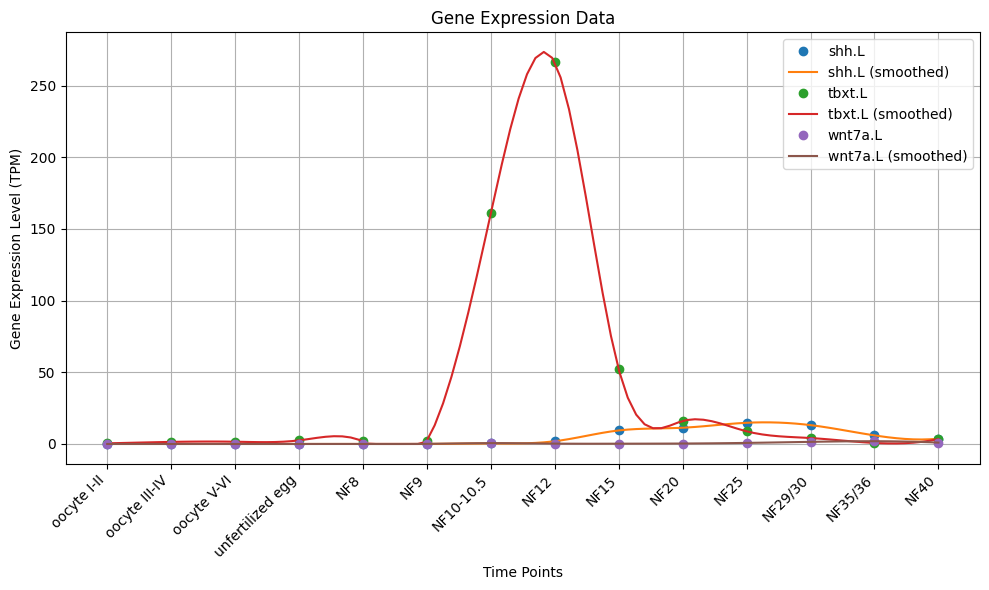

In [21]:
# @title Plot Graph
# Load DataFrame
new_tpm_matrix = pd.read_csv('output.txt', sep='\t', index_col=0)

df = pd.DataFrame(new_tpm_matrix)
df = df[['Gene', 'oocyte - oocyte I-II', 'oocyte - oocyte III-IV', 'oocyte - oocyte V-VI', 'egg - unfertilized egg', 'WE - NF8', 'WE - NF9', 'WE - NF10-10.5', 'WE - NF12', 'WE - NF15', 'WE - NF20', 'WE - NF25', 'WE - NF29/30', 'WE - NF35/36', 'WE - NF40']]

# List of genes to include in the plot
#genes_to_plot = genes_to_plot["pax2.L", "nadsyn1.L", "slc7a5.L"]

# Filter the DataFrame to include only the specified genes
filtered_df = df[df['Gene'].isin(genes_to_plot)]

# Plotting
plt.figure(figsize=(10, 6))

for index, row in filtered_df.iterrows():
    gene = row['Gene']
    expression_values = row.drop('Gene').values
#    time_points = row.drop('Gene').index
    time_points =  ['oocyte I-II', 'oocyte III-IV', 'oocyte V-VI', 'unfertilized egg', 'NF8', 'NF9', 'NF10-10.5', 'NF12', 'NF15', 'NF20', 'NF25', 'NF29/30', 'NF35/36', 'NF40']

# Perform cubic spline interpolation
    f = interp1d(range(len(time_points)), expression_values, kind='cubic')
    x_new = np.linspace(0, len(time_points) - 1, 100)  # Adjust 100 for desired smoothness
    y_new = np.maximum(f(x_new), 0)
    plt.plot(time_points, expression_values, 'o', label=gene)  # Plot original data points
    plt.plot(x_new, y_new, label=f'{gene} (smoothed)')

plt.xlabel('Time Points')
plt.ylabel('Gene Expression Level (TPM)')
plt.title('Gene Expression Data')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(True)
#plt.yscale('log')  # Set y-axis to logarithmic scale
#plt.gca().set_yscale('function', functions=(lambda x: np.log2(x), lambda x: np.exp2(x))) # Set y-axis to logarithmic scale with base 2
#plt.gca().yaxis.set_major_locator(LogLocator(base=2.0)) # Use LogLocator for y-axis ticks
plt.tight_layout()
plt.show()

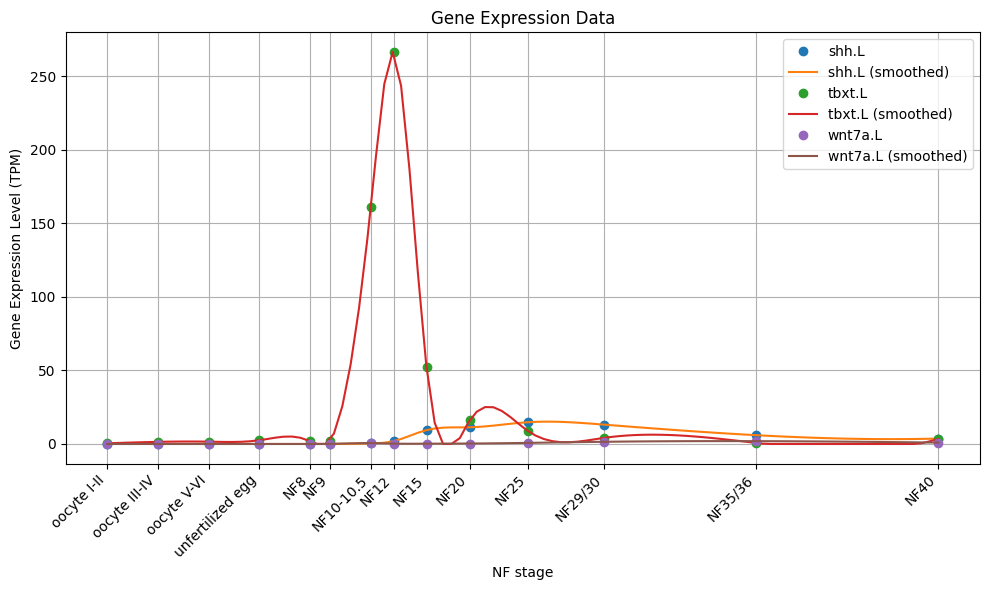

In [22]:
# @title Graph with proper timing
# Given timings
timings = {
    'oocyte - oocyte I-II': 0,
    'oocyte - oocyte III-IV': 5,
    'oocyte - oocyte V-VI': 10,
    'egg - unfertilized egg': 15,
    'WE - NF8': 20,
    'WE - NF9': 22,
    'WE - NF10-10.5': 26,
    'WE - NF12': 28.25,
    'WE - NF15': 31.5,
    'WE - NF20': 35.75,
    'WE - NF25': 41.5,
    'WE - NF29/30': 49,
    'WE - NF35/36': 64,
    'WE - NF40': 82
}

# Create DataFrame
df = pd.DataFrame(new_tpm_matrix)
df = df[['Gene', 'oocyte - oocyte I-II', 'oocyte - oocyte III-IV', 'oocyte - oocyte V-VI',
         'egg - unfertilized egg', 'WE - NF8', 'WE - NF9', 'WE - NF10-10.5', 'WE - NF12',
         'WE - NF15', 'WE - NF20', 'WE - NF25', 'WE - NF29/30', 'WE - NF35/36', 'WE - NF40']]

# Filter the DataFrame to include only the specified genes
filtered_df = df[df['Gene'].isin(genes_to_plot)]

# Plotting
plt.figure(figsize=(10, 6))

for index, row in filtered_df.iterrows():
    gene = row['Gene']
    expression_values = row.drop('Gene').values
    time_points = row.drop('Gene').index

    # Interpolating time points to align with the given timings
    stage_positions = [timings[stage] for stage in time_points]

    # Perform cubic spline interpolation
    f = interp1d(stage_positions, expression_values, kind='cubic')
    x_new = np.linspace(min(stage_positions), max(stage_positions), 100)  # Adjust 100 for desired smoothness
    y_new = np.maximum(f(x_new), 0)

    stage_labels =  ['oocyte I-II', 'oocyte III-IV', 'oocyte V-VI', 'unfertilized egg', 'NF8', 'NF9', 'NF10-10.5', 'NF12', 'NF15', 'NF20', 'NF25', 'NF29/30', 'NF35/36', 'NF40']

    plt.plot(stage_positions, expression_values, 'o', label=gene)  # Plot original data points
    plt.plot(x_new, y_new, label=f'{gene} (smoothed)')  # Plot smoothed line

plt.xlabel('NF stage')  # X-axis represents time in hours
plt.ylabel('Gene Expression Level (TPM)')
plt.title('Gene Expression Data')
plt.xticks(list(timings.values()), stage_labels, rotation=45, ha='right')  # Set custom ticks and labels
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
